# 1. Regression

## 1.1. Load Data and Train Model

In [1]:
from sklearn.linear_model import LinearRegression
from holisticai.datasets import load_dataset
from sklearn.metrics import mean_squared_error
import shap
import numpy as np
import pandas as pd

dataset = load_dataset('us_crime')
dataset = dataset.train_test_split(test_size=0.2, random_state=42)
train = dataset['test']
test = dataset['test']

model = LinearRegression()
model.fit(train['X'], train['y'])

mean_squared_error(test['y'], model.predict(test['X']))

/home/cristian/.local/share/hatch/env/virtual/holisticai/g8_gwgw3/testing/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.013731416251044858

# Create a Custom Feature Importance Calculator

In [2]:
!pip install lime


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip


In [3]:
from holisticai.datasets import Dataset
import lime
import lime.lime_tabular
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

class LIMEImportanceCalculator:
    importance_type : str = "local"
    
    def __init__(self, learning_task, x_train, model):
        if learning_task=="regression":
            self.explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, 
                                feature_names=x_train.columns,
                                discretize_continuous=True,
                                mode='regression')
            self.predict_function = model.predict
            self.feature_names = list(x_train.columns)
        elif learning_task in ["binary_classification","multi_classification"]:
            self.explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, 
                                    feature_names=x_train.columns, 
                                    class_names= model.classes_, 
                                    discretize_continuous=True,
                                    mode='classification')
            self.predict_function = model.predict_proba
            self.feature_names = list(x_train.columns)
        else:
            raise ValueError("Learning task must be regression or classification")
    
    def __call__(self, ds: Dataset):
        importances = []      
        for i in tqdm(range(len(ds)), desc="Computing LIME importance"):
            instance = ds['X'].iloc[i].values.reshape(1, -1)
            exp = self.explainer.explain_instance(instance[0], self.predict_function, num_features=len(self.feature_names))
            exp_values = np.array(list(exp.local_exp.values())[0])
            ranked_imp = exp_values[:, 1]
            rank = exp_values[:, 0].argsort()
            importance = np.zeros_like(ranked_imp)
            importance[rank] = ranked_imp
            importances.append(importance)
        importances = np.stack(importances) 
        return pd.DataFrame(data=np.abs(importances), columns=ds['X'].columns)
    


In [4]:
from holisticai.explainability.metrics import regression_explainability_features
from holisticai.explainability.metrics import compute_explainability_metrics_from_features

feature_importance_fn = LIMEImportanceCalculator("regression", train['X'], model)

xai_features = regression_explainability_features(test['X'], test['y'], model.predict, strategy=feature_importance_fn)

compute_explainability_metrics_from_features(xai_features)

Computing LIME importance: 100%|██████████| 99/99 [00:19<00:00,  5.00it/s]


,value,reference
metric,,
Alpha Importance Score,0.742574,0.0
XAI Ease Score,0.993333,1.0
Position Parity,0.000000,1.0
Rank Alignment,0.167619,1.0
Spread Ratio,0.997367,0.0


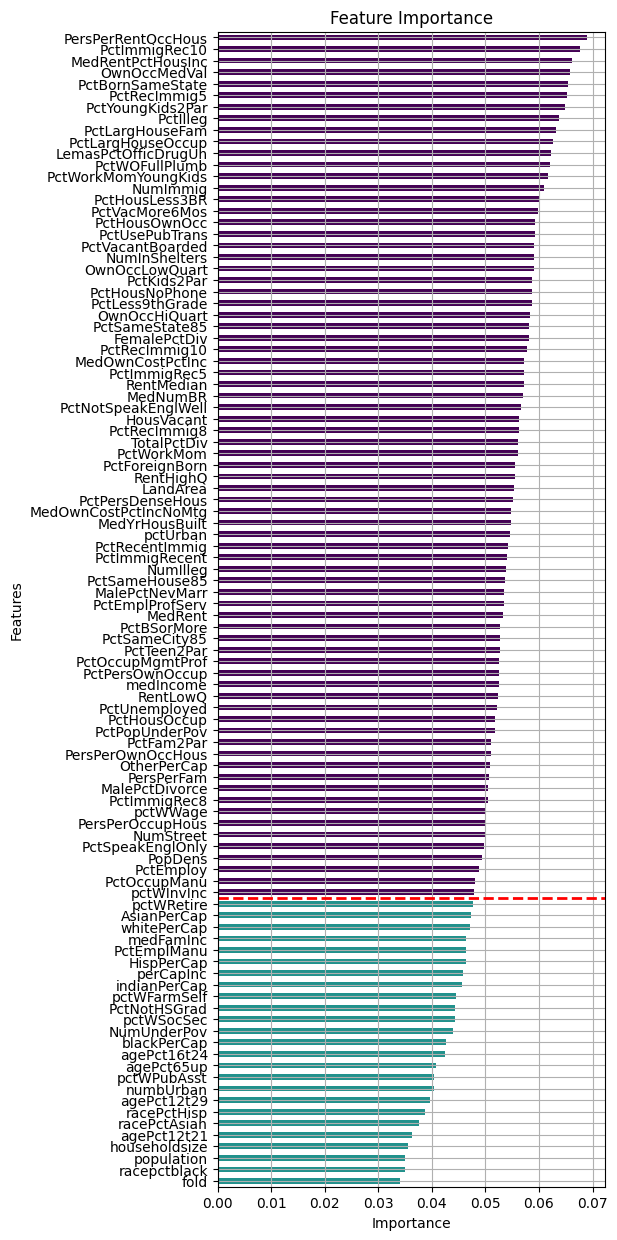

In [5]:
from holisticai.explainability.plots import plot_feature_importance
from matplotlib import pyplot as plt

fig,ax = plt.subplots(1,1, figsize=(5,15))
plot_feature_importance(xai_features.feature_importance, xai_features.ranked_feature_importance, top_n=100, ax=ax)

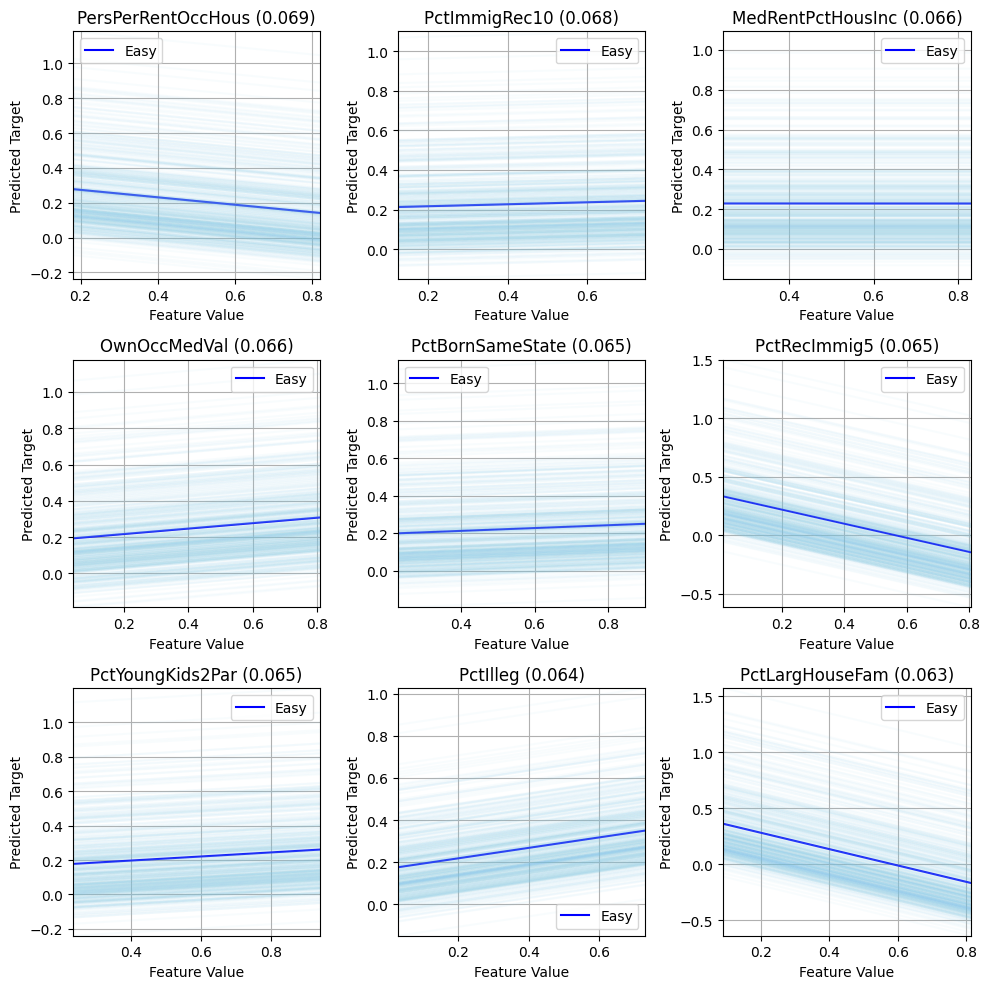

In [6]:
from holisticai.explainability.plots import plot_partial_dependence

plot_partial_dependence(xai_features.partial_dependence, xai_features.ranked_feature_importance, subplots=(3,3), figsize=(10,10))

# 3. Classification

In [7]:
from sklearn.linear_model import LogisticRegression
from holisticai.datasets import load_dataset
from sklearn.metrics import accuracy_score

dataset = load_dataset('adult')
dataset = dataset.train_test_split(test_size=0.2, random_state=42)
train = dataset['test']
test = dataset['test'].sample(200) # For faster computation

model = LogisticRegression()
model.fit(train['X'], train['y'])

accuracy_score(test['y'], model.predict(test['X']))

0.805

In [8]:
from holisticai.explainability.metrics import classification_explainability_features
from holisticai.explainability.metrics import compute_explainability_metrics_from_features

feature_importance_fn = LIMEImportanceCalculator("binary_classification", train['X'], model)

xai_features = classification_explainability_features(test['X'], test['y'], model.predict, model.predict_proba, classes=model.classes_, strategy=feature_importance_fn)

compute_explainability_metrics_from_features(xai_features)

Computing LIME importance: 100%|██████████| 49/49 [00:05<00:00,  9.62it/s]


,value,reference
metric,,
Alpha Importance Score,0.621951,0.0
XAI Ease Score,1.000000,1.0
Position Parity,0.092687,1.0
Rank Alignment,0.517200,1.0
Spread Ratio,0.963461,0.0


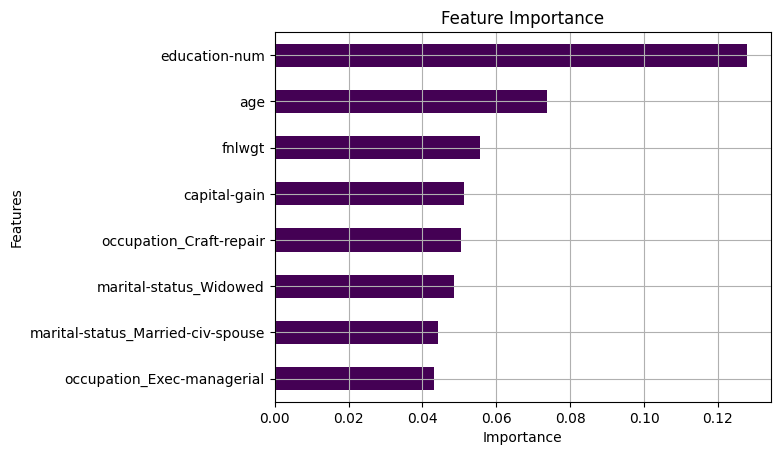

In [9]:
from holisticai.explainability.plots import plot_feature_importance

plot_feature_importance(xai_features.feature_importance, xai_features.ranked_feature_importance, top_n=8)

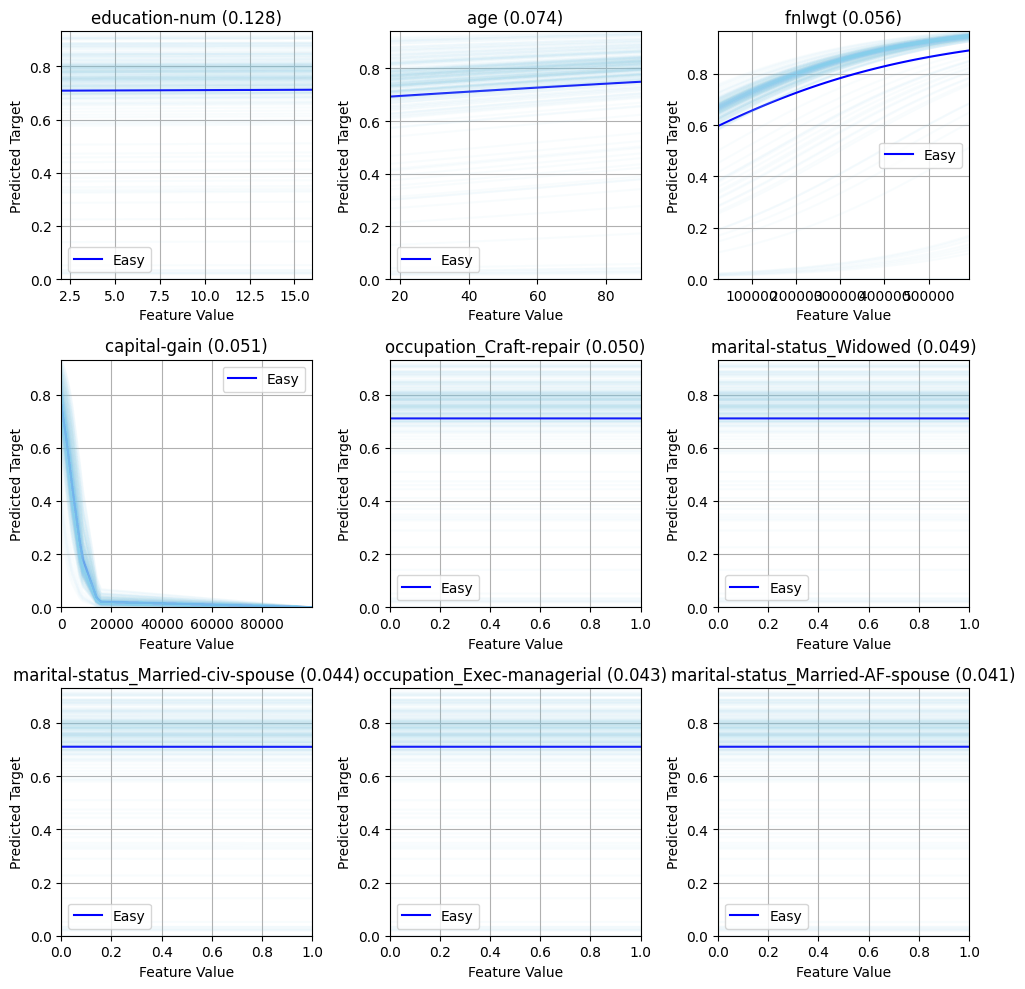

In [10]:
from holisticai.explainability.plots import plot_partial_dependence

class_index = 0 #1
plot_partial_dependence(xai_features.partial_dependence[class_index], xai_features.ranked_feature_importance, subplots=(3,3), figsize=(10,10))

# Multi Classification

In [11]:
from sklearn.linear_model import LogisticRegression
from holisticai.datasets import load_dataset
from sklearn.metrics import accuracy_score

dataset = load_dataset(dataset_name="student_multiclass")
dataset = dataset.train_test_split(test_size=0.2, random_state=42)
train = dataset['test']
test = dataset['test']

model = LogisticRegression()
model.fit(train['X'], train['y'])

accuracy_score(test['y'], model.predict(test['X']))

0.810126582278481

In [12]:
from holisticai.explainability.metrics import multiclass_explainability_features
from holisticai.explainability.metrics import compute_explainability_metrics_from_features

feature_importance_fn = LIMEImportanceCalculator("multi_classification", train['X'], model)

xai_features = multiclass_explainability_features(test['X'], test['y'], model.predict, model.predict_proba, classes=model.classes_, strategy=feature_importance_fn)

compute_explainability_metrics_from_features(xai_features)

Computing LIME importance: 100%|██████████| 36/36 [00:02<00:00, 12.84it/s]


,value,reference
metric,,
Alpha Importance Score,0.615385,0.0
XAI Ease Score,0.958333,1.0
Position Parity,0.000000,1.0
Rank Alignment,0.259236,1.0
Spread Ratio,0.960451,0.0


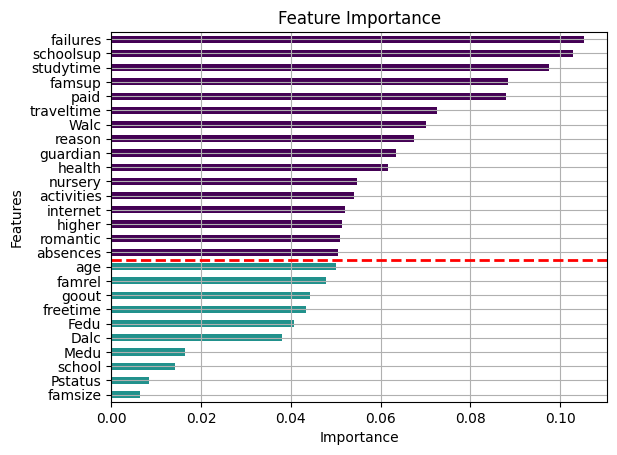

In [13]:
from holisticai.explainability.plots import plot_feature_importance

plot_feature_importance(xai_features.feature_importance, xai_features.ranked_feature_importance, top_n=30)

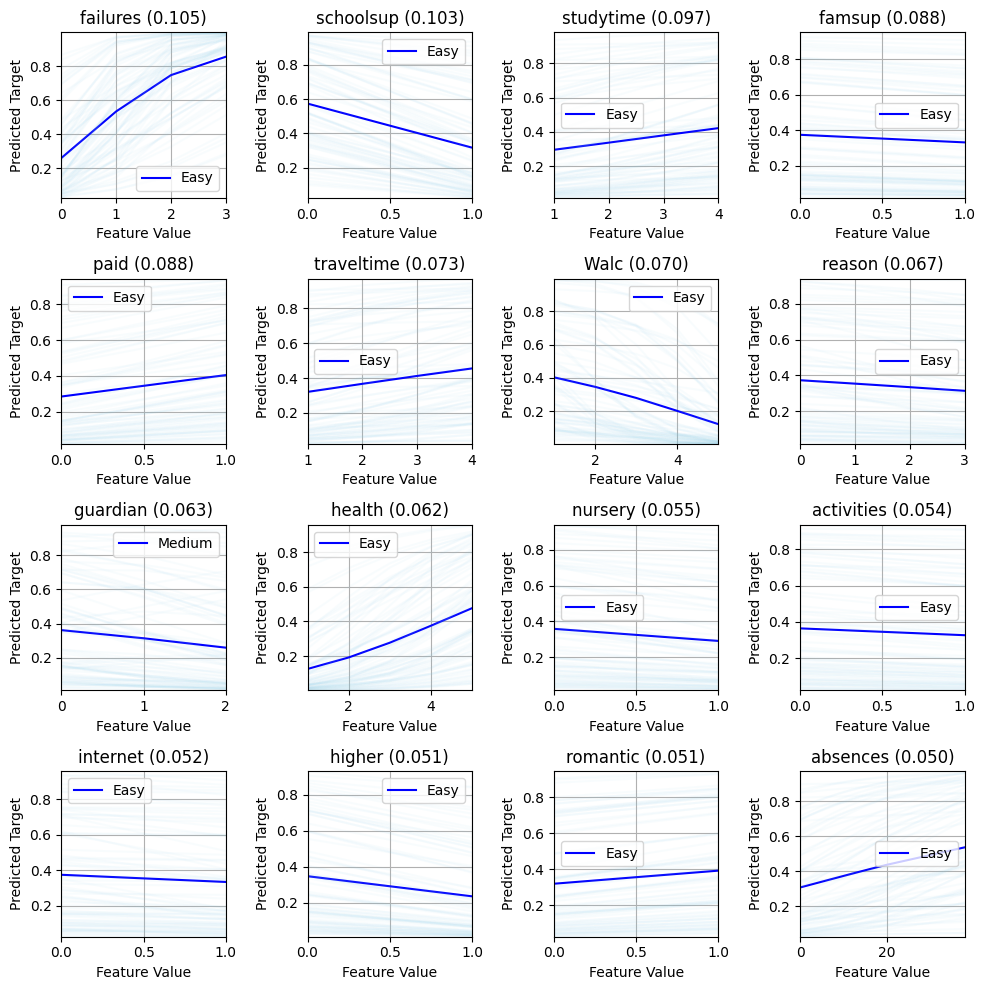

In [14]:
from holisticai.explainability.plots import plot_partial_dependence

class_index = 0 #1
plot_partial_dependence(xai_features.partial_dependence[0], xai_features.ranked_feature_importance, subplots=(4,4), figsize=(10,10))